# Burgers equation in 1D: joint alternate estimation for inverse problem

TODO

**In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\theta$**. The dynamic, boundary and initial condition losses will be the same as in the [introductory notebook](https://mia_jinns.gitlab.io/jinns/Notebooks/Tutorials/implementing_your_own_PDE_problem/) but we will also **make use of available observations** and we will also **differentiate the dynamic loss with respect to the equation parameter $\theta$**.

We will work with the Burgers equation:

$$
\begin{equation}
\tag{PDE}
\begin{cases}
&\frac{\partial}{\partial t} u_\nu(t,x) + u_\nu(t,x)\frac{\partial}{\partial x} u_\nu(t,x) - \theta \frac{\partial^2}{\partial x^2} u_\nu(t,x) = 0,  \forall (t,x)\in I\times\Omega,&\text{ (Dynamic)} \\
&u_\nu(0, x) = -\sin(\pi x), \forall x\in\partial\Omega, &\text{ (initial condition)}\\
&u_\nu(t,-1)=u_\nu(t,1)=0, \forall t\in I, &\text{ (boundary condition)}
\end{cases}
\end{equation}
$$

We choose the time interval $I=[0,1]$ and the domain $\Omega=[-1,1]$. We denote by $\partial\Omega$ the boundary domain.

Therefore, we aim at solving:

$$
\hat{\nu},\hat{\theta}=\text{argmin}_{\nu,\theta} \mathcal{L}(\nu,\theta)
$$
with the loss:

$$
\begin{align*}
\mathcal{L}(\nu,\theta)&=\sum_{i}^{n_x}\sum_j^{n_t}\Big(u_\nu(t_j,x_i) + u_\nu(t_j,x_i)\frac{\partial}{\partial x}
          u_\nu(t_j,x_i) - \theta \frac{\partial^2}{\partial x^2} u_\nu(t_j,x_i)\Big)^2\\
&+w_{ic}\sum_i^{nx}\Big(u_\nu(0,x_i)-(-\sin(\pi x_i))\Big)^2\\
&+w_{bc}\sum_j^{n_t}\Big[\Big(u_\nu(t_j,-1)\Big)^2+\Big(u_\nu(t_j,1)\Big)^2\Big]
\end{align*}
$$

**Note that this approach could be much more refined by working on the optimization scheme**: alternative optimizers for $\nu$ and $\theta$, pre-training for $\nu$ only, etc. This tutorial only gives a first idea on how to tackle inverse problems with **jinns**.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt

figsize = (3, 3)
plt.rcParams["figure.figsize"] = figsize

In [4]:
key = jax.random.PRNGKey(42)

## Define the equation parameters

In [5]:
# True is : theta = 1 / (100 * jnp.pi)
key, subkey = jax.random.split(key)
theta_ori = jnp.array([1 / (100 * jnp.pi)])
print(f"{theta_ori=}")
theta = theta_ori + jax.random.normal(subkey, shape=(1,)) * 0.05
print(f"{theta=}")

theta_ori=Array([0.0031831], dtype=float32)
theta=Array([0.0334713], dtype=float32)


## Observations

We use artificial observations from the estimated solution from the other notebook on Burgers equation. You can [download it here](https://gitlab.com/mia_jinns/jinns/-/raw/main/Notebooks/Tutorials/burger_solution_grid.npy?.ref_type=heads&inline=false)

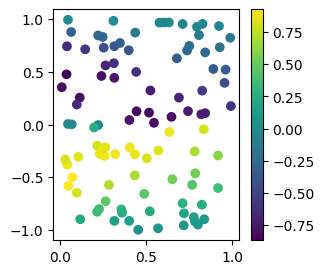

In [6]:
observations = jnp.load("burgers_solution_grid.npy")
key, subkey = jax.random.split(key)
size_subsample = 100
time_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[0], 1),
    shape=(size_subsample,),
    replace=True,  # we do not have enough observations
)
key, subkey = jax.random.split(key)
omega_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[1], 1),
    shape=(size_subsample,),
    replace=True,  # we do not have enough observations
)
obs_batch = observations[time_subsample, omega_subsample]

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()

__Optionally blur the observed values__

In [7]:
# obs_batch_ori = obs_batch.copy()
# key, subkey = jax.random.split(key)
# obs_batch = obs_batch.at[:, 2].set(
#     obs_batch[:, 2] + jax.random.normal(subkey, obs_batch[:, 2].shape) * 0.01
# )


# plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
# plt.colorbar()
# plt.show()

## Estimate the solution to the Burgers equation as well as the viscosity coefficient

*Define the domain and the associated data generator*

In [8]:
n = 5000
ni = 5000
nb = 2
domain_batch_size = 1000
initial_batch_size = 1000
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

*Define the data generator for the observations*

In [9]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    key=subkey,
    obs_batch_size=32,
    observed_pinn_in=obs_batch[:, :2],
    observed_values=obs_batch[:, 2:3],
)

*Define the PINN*

Create the neural network architecture for the PINN with `equinox`.

In [10]:
eqx_list = (
    (eqx.nn.Linear, 2, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 1),
)
key, subkey = jax.random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="nonstatio_PDE"
)

*Define the jinns parameter object*

In [11]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "theta": theta,
    },
)

*Define the loss weights*

In [12]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1.0,
    initial_condition=1.0,
    boundary_loss=1.0,
    observations=1.0,
)

*Define the initial condition*

Text(0.5, 1.0, 'Init condition $u_0$')

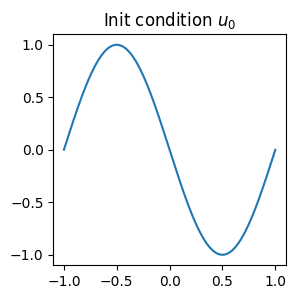

In [13]:
def u0(x):
    return -jnp.sin(jnp.pi * x)


plt.plot(
    train_data.domain[:, 1].sort(axis=0),
    jax.vmap(u0, (0), 0)(train_data.domain[:, 1].sort(axis=0)),
)
plt.title(r"Init condition $u_0$")

*Define the dynamic loss term*

In [14]:
from jinns.loss import PDENonStatio

from jaxtyping import Float, Array

import jinns.parameters


class BurgersEquation(PDENonStatio):
    r"""
    Return the Burgers dynamic loss term (in 1 space dimension):

    $$
        \frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
        u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0
    $$
    """

    def equation(
        self,
        t_x: Float[Array, "1+dim"],
        u: eqx.Module,
        params: jinns.parameters.Params,
    ) -> Float[Array, "1"]:
        r"""
        Evaluate the dynamic loss at :math:`(t,x)`.

        Parameters
        ---------
        t_x
            A collocation point in $I\times\Omega$
        u
            The PINN
        params
            The dictionary of parameters of the model.
        """
        u_ = lambda t_x: jnp.squeeze(u(t_x, params)[u.slice_solution])
        du_dtx = jax.grad(u_)
        d2u_dx_dtx = jax.grad(lambda t_x: du_dtx(t_x)[1])
        du_dtx_values = du_dtx(t_x)

        return du_dtx_values[0:1] + self.Tmax * (
            u_(t_x) * du_dtx_values[1:2] - params.eq_params.theta * d2u_dx_dtx(t_x)[1:2]
        )


be_loss = BurgersEquation(Tmax=1)

*Define how to differentiate each term of the loss* Note that the main `params` of the problem must be passed since we use the `from_str()` constructor

In [15]:
derivative_keys_nu_and_theta = jinns.parameters.DerivativeKeysPDENonStatio.from_str(
    dyn_loss=jinns.parameters.Params(
        nn_params=True,
        eq_params={
            "theta": True,
        },
    ),
    boundary_loss="nn_params",
    initial_condition="nn_params",
    observations="nn_params",
    params=init_params,
)

*Define the PDE PINN losses*

In [16]:
loss_nu_and_theta = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    derivative_keys=derivative_keys_nu_and_theta,
    omega_boundary_fun=lambda t_dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
)

*Up to this point, the content is the same as in the joint vanilla estimation tutorial. But here we diverge. We will need to construct the object needed for the `jinns.solve_alternate()` call. And, first of all, we will start with a PINN pretraining of observations only. One argument in favor of such pretraining is that we will start the alternate procedure with a number of iterations on $\theta$ only: to avoid a collapse to $0$, it would be useful for the PINN to be pretrained.*

PINN initialization with observations only starting
Initialization time: 3.8627231121063232

Compilation took
 6.545854330062866 

[train] Iteration 0: loss value = 0.36093413829803467
[train] Iteration 100: loss value = 0.18179762363433838
[train] Iteration 200: loss value = 0.021700037643313408
[train] Iteration 300: loss value = 0.0060821473598480225
[train] Iteration 400: loss value = 0.009547300636768341
[train] Iteration 500: loss value = 0.01577889733016491
[train] Iteration 600: loss value = 0.009314109571278095
[train] Iteration 700: loss value = 0.007158844731748104
[train] Iteration 800: loss value = 0.008239654824137688
[train] Iteration 900: loss value = 0.0020724781788885593

Stopping main optimization loop, cause: max iteration is reached

Training took
 1.9412622451782227 


Final iteration 1000: train loss value = 0.0033719856292009354


(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'u(t,x) after pretraining'}>)

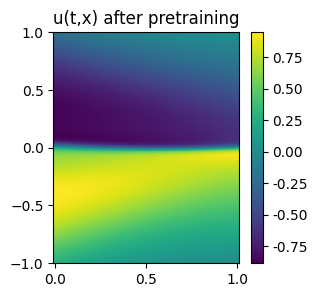

In [17]:
pretrain_loss = eqx.tree_at(
    lambda pt: (
        pt.loss_weights.dyn_loss,
        pt.loss_weights.boundary_loss,
        pt.loss_weights.initial_condition,
    ),
    loss_nu_and_theta,
    (0.0, 0.0, 0.0),
)
pretrain_tx = optax.adam(learning_rate=1e-3)

key, subkey = jax.random.split(key)
print("PINN initialization with observations only starting")
pretrain_params, loss_values, loss_by_term_dict, _, _, _, _, _, _, _, _, _ = (
    jinns.solve(
        n_iter=1000,
        init_params=init_params,
        data=train_data,
        optimizer=pretrain_tx,
        loss=pretrain_loss,
        obs_data=obs_data,
        print_loss_every=100,
        key=subkey,
    )
)
u_est = lambda t_x: u(t_x, pretrain_params)
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)
jinns.plot.plot1d_image(
    u_est,
    xdata=val_xdata,
    times=val_times,
    cmap="viridis",
    colorbar=True,
    figsize=figsize,
    title="u(t,x) after pretraining",
)

In [18]:
jnp.allclose(
    loss_values, loss_by_term_dict.observations
)  # check that we only use observations

Array(True, dtype=bool)

*We know start the alternate training*

In [33]:
# number of alternate iterations
n_iter = 30
# number of iterations for each solver
n_iter_by_solver = jinns.parameters.Params(nn_params=400, eq_params={"theta": 10})
# solver for each set of parameters
optimizers = jinns.parameters.Params(
    nn_params=optax.adamw(learning_rate=1e-5), eq_params={"theta": optax.rprop(1e-4)}
)
# parameter to record the values of
tracked_params = jinns.parameters.Params(eq_params={"theta": True})

In [34]:
params, loss_values, loss_by_term_dict, _, _, _, stored_params, _, _, _ = (
    jinns.solve_alternate(
        n_iter=n_iter,
        n_iter_by_solver=n_iter_by_solver,
        init_params=pretrain_params,
        data=train_data,
        loss=loss_nu_and_theta,  # take the complete loss!
        optimizers=optimizers,
        verbose=True,
        obs_data=obs_data,
        key=subkey,
        tracked_params=tracked_params,
    )
)

Initialization time: 17.46951150894165
jinns alternate solver iteration 0
jinns alternate solver iteration 1
jinns alternate solver iteration 2
jinns alternate solver iteration 3
jinns alternate solver iteration 4
jinns alternate solver iteration 5
jinns alternate solver iteration 6
jinns alternate solver iteration 7
jinns alternate solver iteration 8
jinns alternate solver iteration 9
jinns alternate solver iteration 10
jinns alternate solver iteration 11
jinns alternate solver iteration 12
jinns alternate solver iteration 13
jinns alternate solver iteration 14
jinns alternate solver iteration 15
jinns alternate solver iteration 16
jinns alternate solver iteration 17
jinns alternate solver iteration 18
jinns alternate solver iteration 19
jinns alternate solver iteration 20
jinns alternate solver iteration 21
jinns alternate solver iteration 22
jinns alternate solver iteration 23
jinns alternate solver iteration 24
jinns alternate solver iteration 25
jinns alternate solver iteration 26

## Results

In [35]:
print("True theta", theta_ori)
print("Initial guess for theta", theta)
print("Estimated theta", stored_params.eq_params.theta[-1])

True theta [0.0031831]
Initial guess for theta [0.0334713]
Estimated theta [0.01569536]


*Plot the tracked parameters*

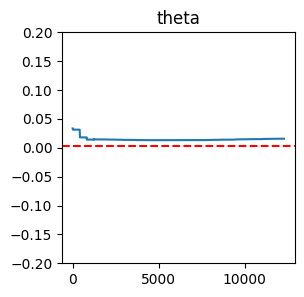

In [36]:
colors = ["blue"]
plt.plot(stored_params.eq_params.theta)
plt.axhline(y=theta_ori, color="r", linestyle="--")
plt.title("theta")
plt.ylim([-0.2, 0.2])
plt.show()

*Plot the loss values*

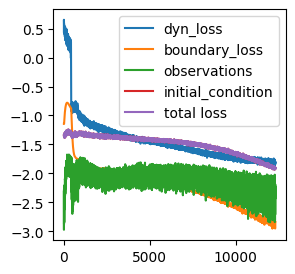

In [37]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(loss_values), label="total loss")
plt.legend()
plt.show()

*Plot the PDE solutions learned by the PINN*

(<Figure size 300x300 with 2 Axes>, <Axes: title={'center': 'u(t,x)'}>)

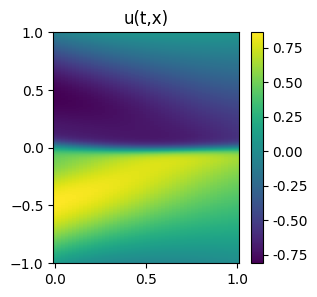

In [31]:
u_est = lambda t_x: u(t_x, params)
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)
jinns.plot.plot1d_image(
    u_est,
    xdata=val_xdata,
    times=val_times,
    cmap="viridis",
    colorbar=True,
    figsize=figsize,
    title="u(t,x)",
)

<Axes: xlabel='x', ylabel='$u(t_i, x)$'>

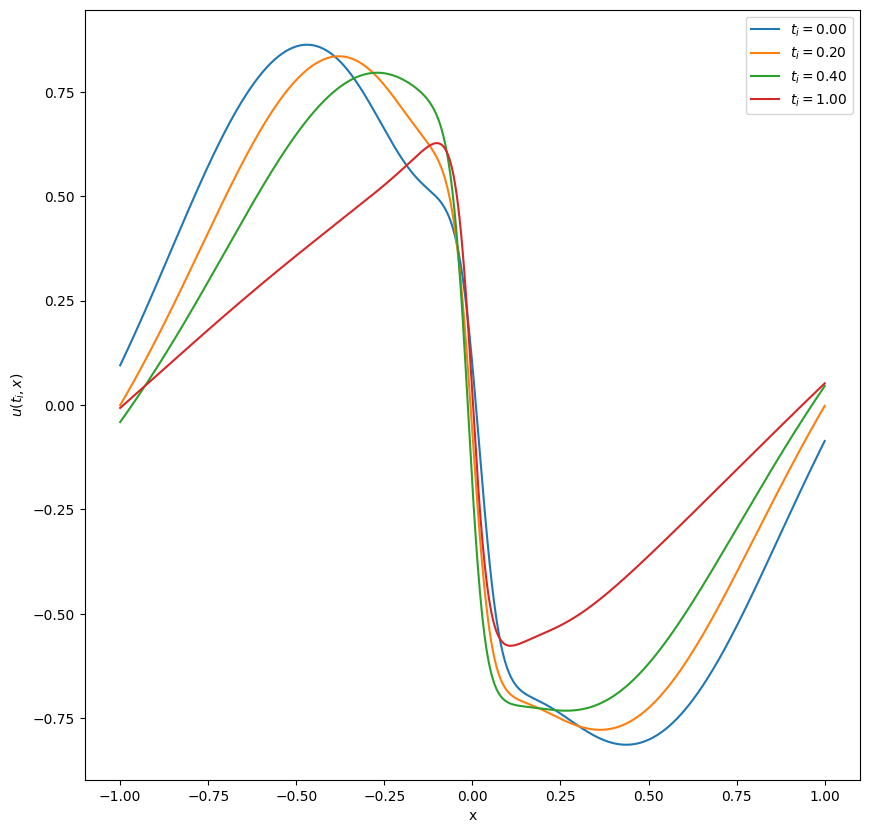

In [32]:
time_slices = [0, 0.2, 0.4, 1]
jinns.plot.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices)